<a href="https://colab.research.google.com/github/suhacker1/SecureML_Tests/blob/master/Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stealing Machine Learning Models via Prediction APIs 

## Create Victim Model

In [1]:
!pip install pytorch-lightning

In [0]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

In [0]:
class LightningMNISTClassifier(pl.LightningModule):

  def __init__(self):
    super(LightningMNISTClassifier, self).__init__()

    # mnist images are (1, 28, 28) (channels, width, height) 
    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
      batch_size, channels, width, height = x.size()

      # (b, 1, 28, 28) -> (b, 1*28*28)
      x = x.view(batch_size, -1)

      # layer 1 (b, 1*28*28) -> (b, 128)
      x = self.layer_1(x)
      x = torch.relu(x)

      # layer 2 (b, 128) -> (b, 256)
      x = self.layer_2(x)
      x = torch.relu(x)

      # layer 3 (b, 256) -> (b, 10)
      x = self.layer_3(x)

      # probability distribution over labels
      x = torch.log_softmax(x, dim=1)

      return x

  def cross_entropy_loss(self, logits, labels):
    return F.nll_loss(logits, labels)

  def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, y)

      logs = {'train_loss': loss}
      return {'loss': loss, 'log': logs}

  def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, y)
      return {'val_loss': loss}

  def validation_epoch_end(self, outputs):
      # called at the end of the validation epoch
      # outputs is an array with what you returned in validation_step for each batch
      # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
      avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      tensorboard_logs = {'val_loss': avg_loss}
      return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

  def prepare_data(self):
    # transforms for images
    transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.1307,), (0.3081,))])
      
    # prepare transforms standard to MNIST
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    self.mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    
    self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=64, num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=64, num_workers=4)

  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=64, num_workers=4)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer
    
  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return {'test_loss': F.cross_entropy(y_hat, y)}

  def test_epoch_end(self, outputs):
    avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    tensorboard_logs = {'test_loss': avg_loss}
    return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}


In [4]:
model = LightningMNISTClassifier()

trainer = pl.Trainer(gpus=1, max_epochs=13)

trainer.fit(model)

trainer.test()

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33 K  
2 | layer_3 | Linear | 2 K   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.1316, device='cuda:0'),
 'test_loss': tensor(0.1316, device='cuda:0')}
--------------------------------------------------------------------------------



In [0]:
model.freeze()
model.eval()
model.cuda()

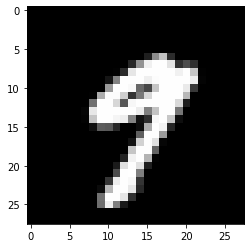

In [79]:
dataset = model.mnist_test

x, _ = dataset[20] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')
x = x.cuda() 
x = x.resize_(1, 28, 28, 1)

In [0]:
def query(image):
    prediction = model(image)
    np_prediction = prediction.cpu().numpy()
    label = np.argmax(np_prediction)
    return prediction, np_prediction, label

In [0]:
pred_x, np_pred_x, label_x = query(x)

In [98]:
label_x

9

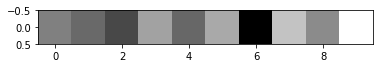

In [101]:
plt.imshow(np_pred_x, cmap='gray')